<a href="https://colab.research.google.com/github/EmanueleGiavardi/BSP_project/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from modules.StochasticProcess import StochasticProcess
from modules.BaselineWanderRemover import BaselineWanderRemover
from modules.QRSdetector import QRSdetector

In [33]:
sp = "a01"
data_extension = ".csv"
gt_extension = ".fqrs.txt"
data_path = "../data/set-a-text"

sp_path = os.path.join(data_path, sp+data_extension)
gt_path = os.path.join(data_path, sp+gt_extension)

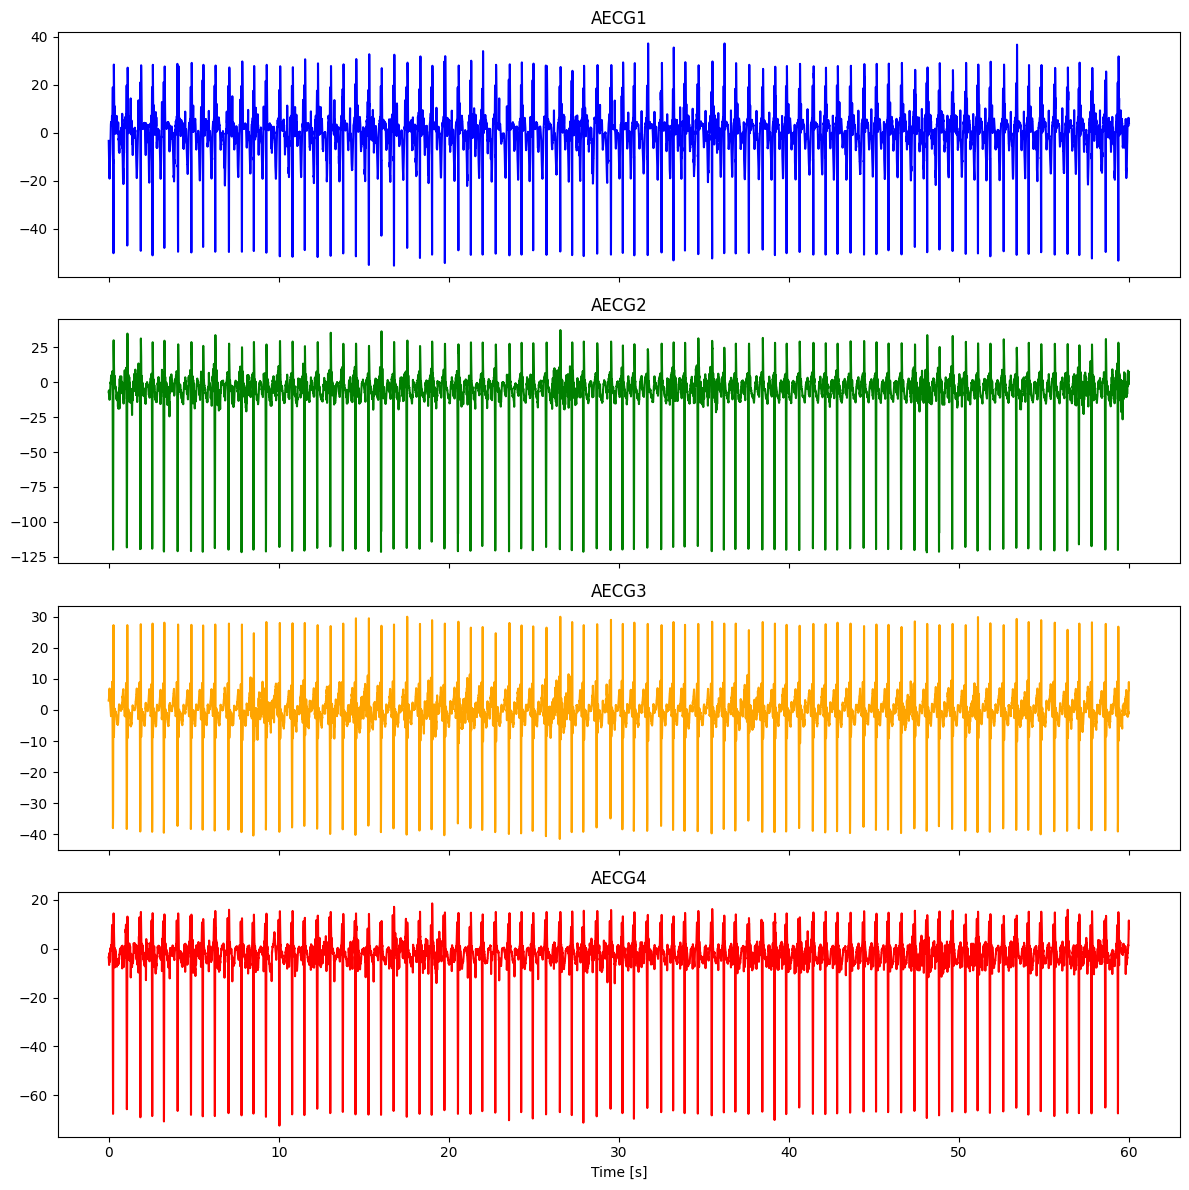

In [40]:
def extract_stochastic_process(filename, num_realizations):
    df = pd.read_csv(filename, skiprows=2, header=None)
    realizations, labels = [], []
    for i in range (1,num_realizations+1):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        realizations.append(AECG_cleaned.astype(float))
        labels.append("AECG"+str(i))

    return realizations, labels

num_realizations = 4
realizations, labels = extract_stochastic_process(sp_path, num_realizations)
sr = 1000 
colors = ['blue', 'green', 'orange', 'red']

SP = StochasticProcess(num_realizations, realizations, labels, colors, sr)
SP.plot()

# <b>Baseline Wander Remover</b>

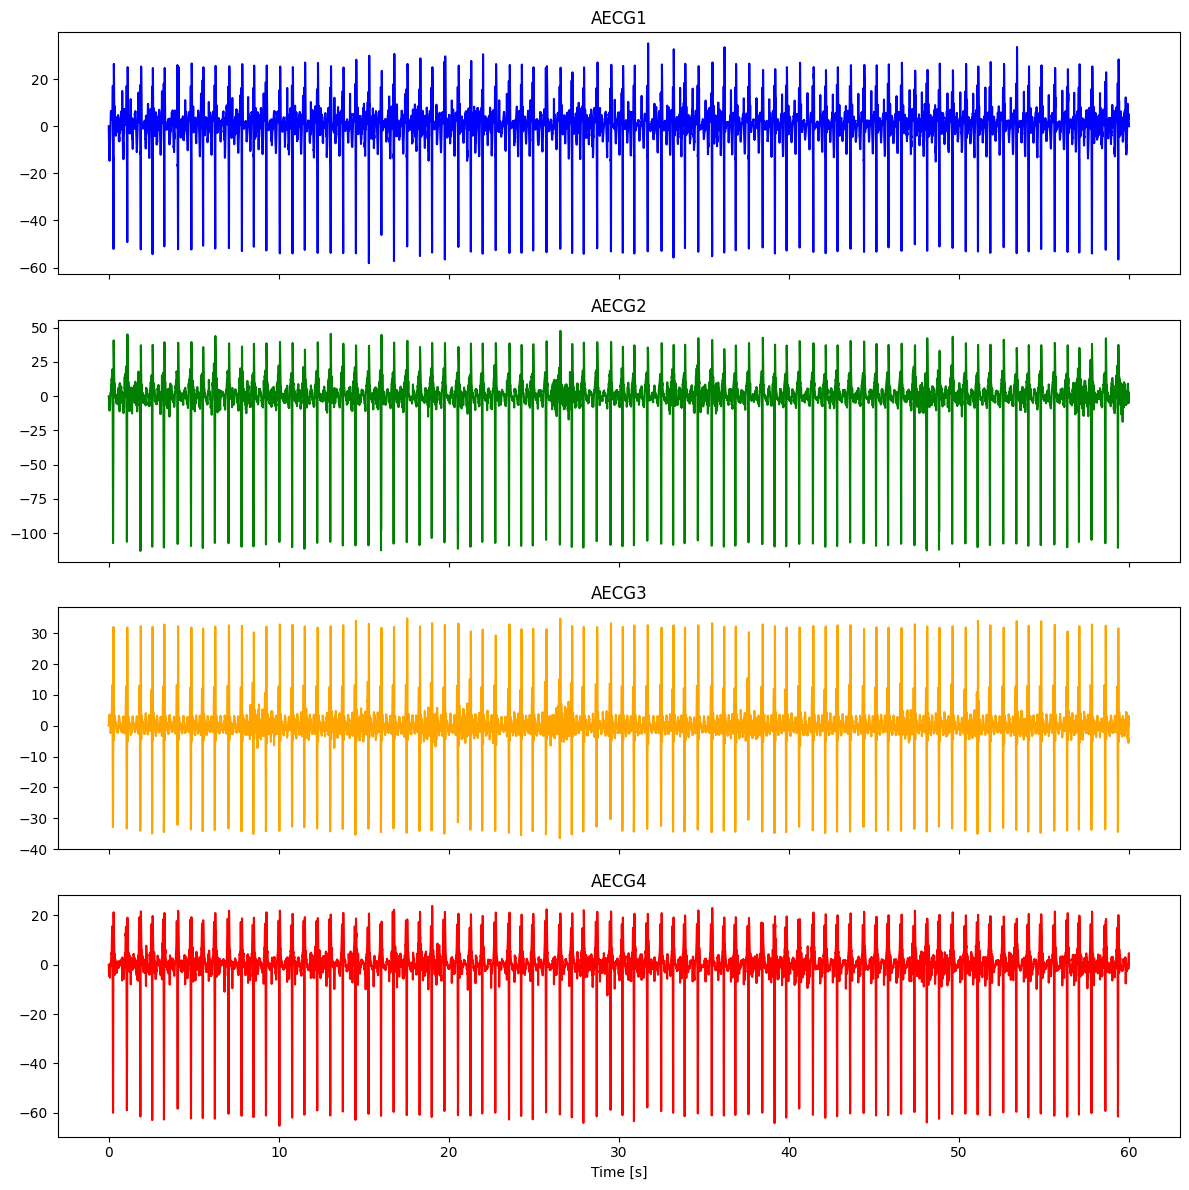

In [41]:
cutoff = 3
num_taps = 1000

bwr = BaselineWanderRemover(sr, cutoff, num_taps+1)

filtered_SP = StochasticProcess(num_realizations, [bwr.highpass_fir_filter(r) for r in SP], labels, colors, sr)

filtered_SP.plot()

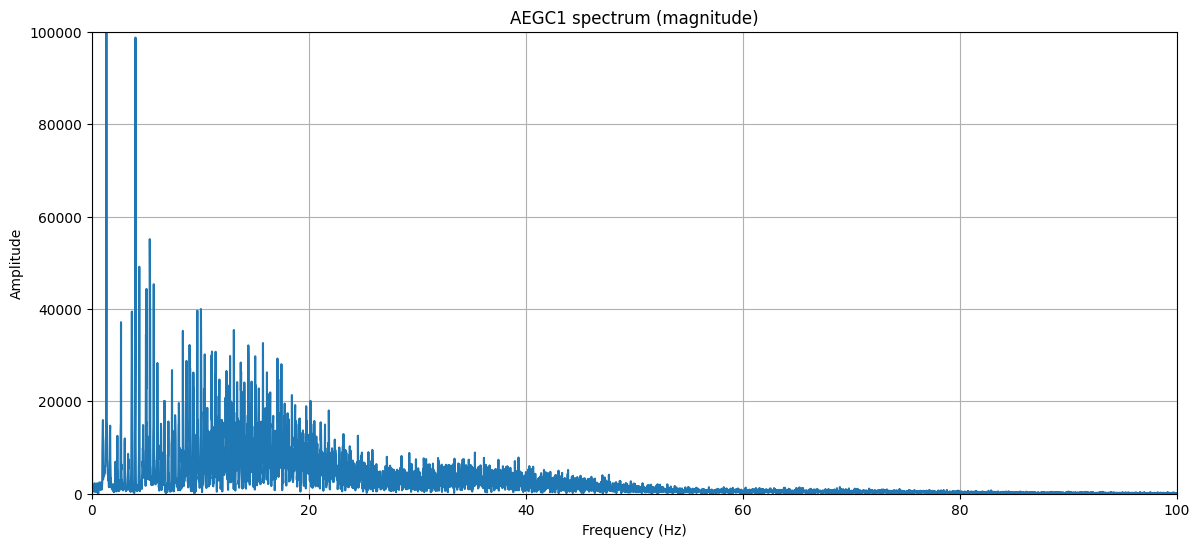

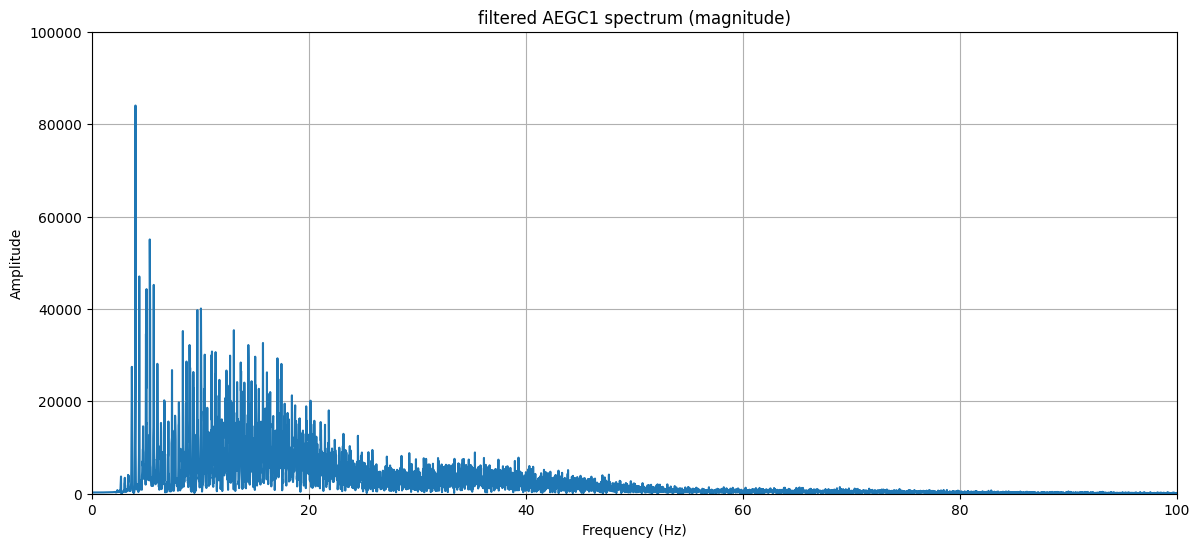

In [42]:
SP.plot_realization_spectrum(0, "AEGC1 spectrum (magnitude)")
filtered_SP.plot_realization_spectrum(0, "filtered AEGC1 spectrum (magnitude)")

# <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)

# **Upsampling**

È sufficiente un upsampling 2X per ottenre la frequenza di campionamento utilizzata nel paper (2000 Hz)

In [57]:
upsample_factor = 2
new_sr = sr * upsample_factor

upsampled_SP = filtered_SP.resample_process(new_sr)
upsampled_time = upsampled_SP.get_timestamps()

# **Maternal QRS Detector**



### **1) QRS enhancement method**

L'idea è quella di sfruttare la forte correlazione tra le componenti QRS dei vari segnali e la bassa correlazione tra il rumore che li caratterizza, assumendo che ciascuna realizzazione del processo sia caratterizzata da queste due componenti.
Passaggi:

1. Normalizzazione dei canali, dividendo ciascun canale per la sua norma Euclidea
2. Applicazione della PCA sui canali
3. estrazione della prima componente come ECG con complessi QRS rafforzati

Questa procedura genera un segnale $\tilde{x}$ associato alla componente con maggiore varianza



In [50]:
maternal_template_duration = 0.10
maternal_threshold_factor = 0.5

qrs_detector = QRSdetector(upsampled_SP, maternal_template_duration, maternal_threshold_factor, new_sr)
maternal_enhanced_QRS, maternal_explained_variance = qrs_detector.get_enhanced_QRS()

Explained variance of PC1 (Maternal QRS): 68%


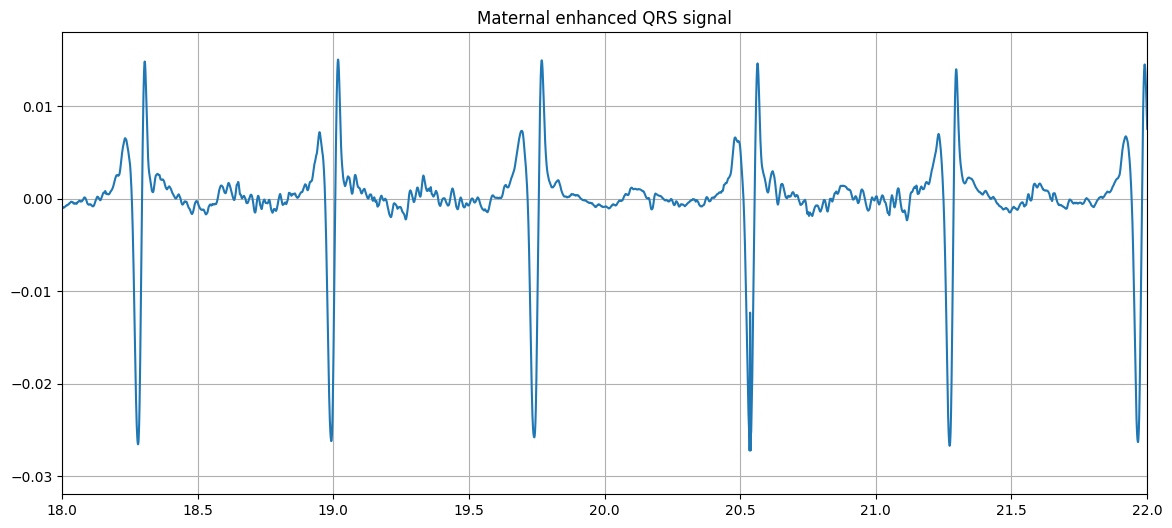

In [58]:
print(f"Explained variance of PC1 (Maternal QRS): {round(maternal_explained_variance)}%")
plt.figure(figsize=(14, 6))
plt.plot(upsampled_time, maternal_enhanced_QRS)
plt.title('Maternal enhanced QRS signal')
plt.xlim(18, 22)
plt.grid(True)
plt.show()

### **2) QRS detection method**

L'idea qui è quella di usare un template QRS $h(t)$ e di calcolare la cross-correlazione $R_{\tilde{x},h}(τ)$ con il segnale $\tilde{x}$.

I massimi locali (picchi) di $R_{\tilde{x},h}(τ)$ saranno salvati in un vettore `R = [r1, r2, ... , rN]` che identificherà le N posizioni dei picchi QRS della madre

In [54]:
maternal_qrs_template = qrs_detector.create_qrs_template(maternal_enhanced_QRS)

Maternal QRS template length in samples: 200


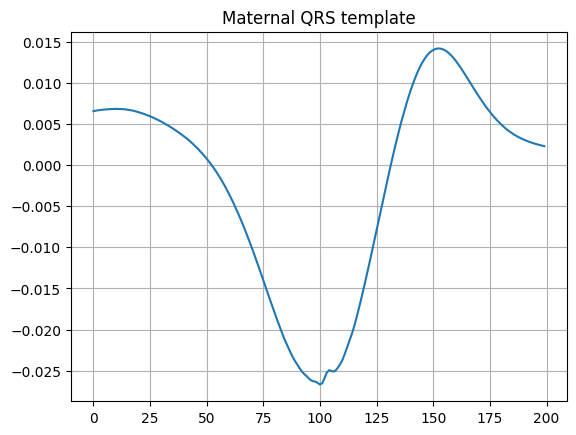

In [55]:
print(f"Maternal QRS template length in samples: {len(maternal_qrs_template)}")
plt.plot(maternal_qrs_template)
plt.title('Maternal QRS template')
plt.grid(True)
plt.show()

In [56]:
maternal_peaks, maternal_cross_corr = qrs_detector.detect_qrs(maternal_enhanced_QRS, maternal_qrs_template)

Maternal QRS peaks detected: 80, with correlation threshold factor: 50 %


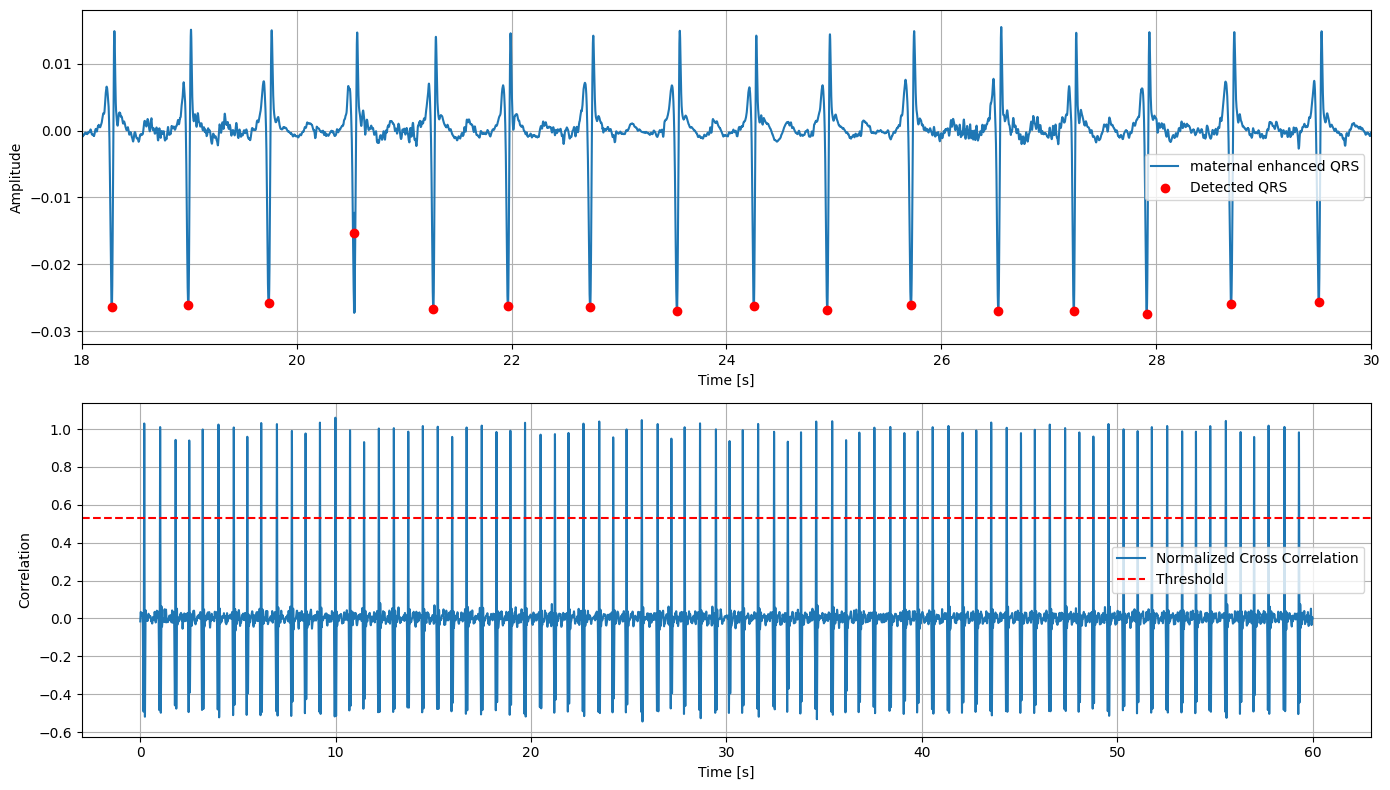

In [60]:
corr_max = np.max(maternal_cross_corr)
print(f"Maternal QRS peaks detected: {len(maternal_peaks)}, with correlation threshold factor: {round(maternal_threshold_factor*100)} %")

plt.figure(figsize=(14, 8))

# Maternal Enhanced QRS (with detected peaks)
plt.subplot(2, 1, 1)
plt.plot(upsampled_time, maternal_enhanced_QRS, label="maternal enhanced QRS")
plt.scatter(upsampled_time[maternal_peaks], maternal_enhanced_QRS[maternal_peaks], color='red', label="Detected QRS", zorder=2)
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(18, 30)
plt.ylabel("Amplitude")
plt.grid()

# Cross-correlation
plt.subplot(2, 1, 2)
plt.plot(upsampled_time[:len(maternal_cross_corr)], maternal_cross_corr, label="Normalized Cross Correlation")
plt.axhline(y=maternal_threshold_factor*corr_max, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Correlation")
plt.grid()

plt.tight_layout()
plt.show()

# **Maternal ECG Canceller**

Una porzione di MECG è definita nel seguente modo:
- *P wave:* 0.20 s
- *QRS complex:* 0.10 s
- *T wave:* 0.40 s


### **1) MECG identification**

L'MECG è identificato attraverso un metodo basato su finestratura: si costruisce una finestra centrata nel picco del complesso QRS secondo le caratteristiche sopra descritte.
La finestra avrà una durata di 1.40 s, di cui
- 0.25 prima del picco QRS
- 0.45 dopo il picco QRS

In [28]:
P_wave_duration_seconds = 0.20
T_wave_duration_seconds = 0.40

In [29]:
def get_samples_around_QRS(wave_duration_seconds, duration_template_seconds, sf):
    return (wave_duration_seconds + duration_template_seconds/2) * sf

samples_before_QRS = get_samples_around_QRS(P_wave_duration_seconds, duration_template_seconds, new_sf)
samples_after_QRS = get_samples_around_QRS(T_wave_duration_seconds, duration_template_seconds, new_sf)

In [30]:
# salvataggio dei complessi ECG materni per ogni realizzazione in un dizionario:
# real_MECGs["AECG1"] -> [[MECG_1_1], [MECG_1_2], ..., [MECG_1_K]]
# real_MECGs["AECG2"] -> [[MECG_2_1], [MECG_2_2], ..., [MECG_2_K]]
# real_MECGs["AECG3"] -> [[MECG_3_1], [MECG_3_2], ..., [MECG_3_K]]
# real_MECGs["AECG4"] -> [[MECG_4_1], [MECG_4_2], ..., [MECG_4_K]]
#
# dove K è il numero di complessi ECG di ciascuna realizzazione (potrebbe variare da realizzazione a realizzazione)

# salvataggio delle posizioni dei complessi ECG materni per ogni realizzazione in un secondo dizionario:
# real_MECGs_positions["AECG1"] -> [(start_MECG_1_1, end__MECG_1_1), (start_MECG_1_2, end__MECG_1_2), ..., (start_MECG_1_K, end__MECG_1_K)]
# real_MECGs_positions["AECG2"] -> [(start_MECG_2_1, end__MECG_2_1), (start_MECG_2_2, end__MECG_2_2), ..., (start_MECG_2_K, end__MECG_2_K)]
# real_MECGs_positions["AECG3"] -> [(start_MECG_3_1, end__MECG_3_1), (start_MECG_3_2, end__MECG_3_2), ..., (start_MECG_3_K, end__MECG_3_K)]
# real_MECGs_positions["AECG4"] -> [(start_MECG_4_1, end__MECG_4_1), (start_MECG_4_2, end__MECG_4_2), ..., (start_MECG_4_K, end__MECG_4_K)]

def get_real_ECGs(stochastic_process, realizations, samples_before_QRS, samples_after_QRS, peaks):
    real_ECGs = {}
    real_ECGs_positions = {}

    for i in range(N):
        signal, realization = stochastic_process[i], realizations[i]
        real_ECGs[realization] = []
        real_ECGs_positions[realization] = []
        for qrs_peak in peaks:
            if (qrs_peak - samples_before_QRS > 0 and qrs_peak + samples_after_QRS < len(signal)):
                window = signal[int(qrs_peak - samples_before_QRS):int(qrs_peak + samples_after_QRS)]
                real_ECGs[realization].append(window)
                real_ECGs_positions[realization].append((int(qrs_peak - samples_before_QRS), int(qrs_peak + samples_after_QRS)))

    return real_ECGs, real_ECGs_positions

#--------------------------------------------------------------------------------------------------------------------------------------

real_MECGs, real_MECGs_positions = get_real_ECGs(upsampled_SP, realizations, samples_before_QRS, samples_after_QRS, peaks)

### **2) Average MECG**

Sia $x$ il segnale di partenza, ovvero dato dalla somma di ECG materno, ECG fetale e rumore
Viene estratto un complesso MECG medio $μ$ effettuando la media sugli N complessi MECG estratti da $x$ attraverso finestratura.

In [31]:
# salvataggio dei complessi ECG materni medi per ogni realizzazione in un dizionario:
# MECG_averages["AECG1"] -> mu_1: MECG medio della prima realizzazione
# MECG_averages["AECG2"] -> mu_2: MECG medio della seconda realizzazione
# MECG_averages["AECG3"] -> mu_3: MECG medio della terza realizzazione
# MECG_averages["AECG4"] -> mu_4: MECG medio della quarta realizzazione

def get_ECG_averages(real_ECGs):
    ECG_averages = {}

    for realization in real_ECGs:
        mu = np.mean(real_ECGs[realization], axis=0)
        ECG_averages[realization] = mu

    return ECG_averages

#--------------------------------------------------------------------------------------------------------------------------------------

MECG_averages = get_ECG_averages(real_MECGs)

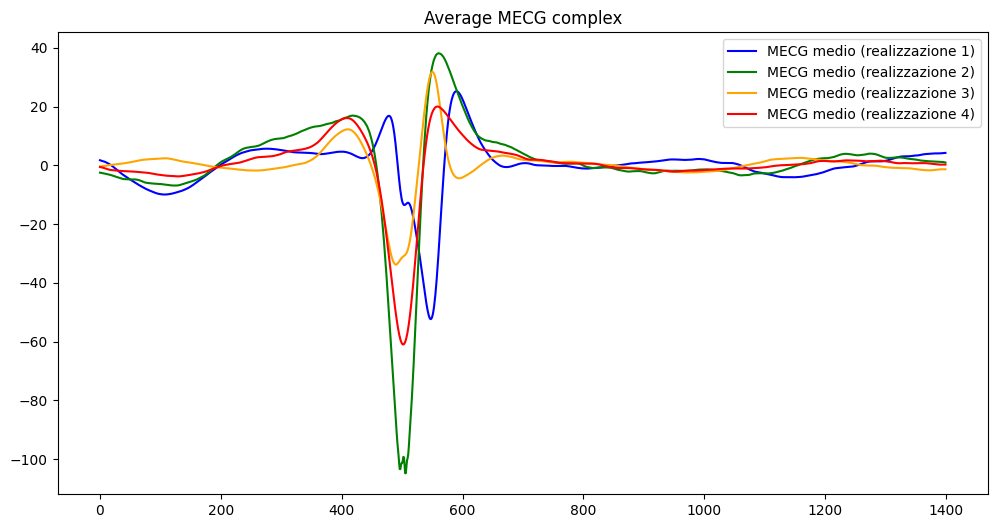

In [32]:
plt.figure(figsize=(12, 6))
for i in range(N): plt.plot(MECG_averages[realizations[i]], color=colors[i], label=f"MECG medio (realizzazione {i+1})")
plt.legend()
plt.title("Average MECG complex")
plt.show()

### **3) MECG Scaling & Subtraction using MSE minimization**

L'MECG estratto $μ$ viene risuddiviso nelle sue tre componenti:
- $\mu_{QRS} →$ contiene il complesso QRS
- $\mu_P →$ contiene l'onda P
- $\mu_T →$ contiene l'onda T

L'idea è la seguente: per ogni complesso MECG appartenente ad $x$, $\mu_{QRS}$, $\mu_P$ e $\mu_T$ vengono oppurtunamente scalati attraverso tre distinti fattori, rispettivamente $a_{QRS}$, $a_P$ e $a_T$, in modo tale che il complesso MECG medio $\mu$ matchi esattamente con il complesso MECG reale $m$.

Facendo ciò si ottiene una stima più accurata del singolo complesso MECG. Questa stima, chiamata $\hat{m}$, è definita come segue:

\begin{align*}
    \hat{m} = Ma
\end{align*}

dove $a$ è l'array contenente i tre fattori di scaling
\begin{bmatrix}
a_P\\
a_{QRS}\\
a_T
\end{bmatrix}

e $M$ è una matrice quadrata 3x3 avente le tre componenti di $\mu$ sulla diagonale:

\begin{bmatrix}
\mu_P & 0 & 0\\
0 & \mu_{QRS} & 0\\
0 & 0 & \mu_T
\end{bmatrix}

Ora, dal momento che il sample rate a questo punto della procedura è pari a 2000 Hz:
- la lunghezza di $\mu_P$ è $0.20 s \times 2000 Hz = 400$ campioni
- la lunghezza di $\mu_{QRS}$ è $0.10 s \times 2000 Hz = 200$ campioni
- la lunghezza di $\mu_T$ è $0.40 s \times 2000 Hz = 800$ campioni

Dunque $M$ in versione esplicita può essere rappresentata come:

\begin{bmatrix}
\mu_P[0] & 0 & 0\\
\mu_P[1] & 0 & 0\\
... & 0 & 0\\
\mu_P[399] & 0 & 0\\
0 & \mu_{QRS}[0] & 0\\
0 & \mu_{QRS}[1] & 0\\
0 & ... & 0\\
0 & \mu_{QRS}[199] & 0\\
0 & 0 & \mu_T[0]\\
0 & 0 & \mu_T[1]\\
0 & 0 & ...\\
0 & 0 & \mu_T[799]\\
\end{bmatrix}


Per trovare $a$, viene minimizzato l'$MSE$ tra il complesso MECG stimato $\hat{m} = Ma$ e il reale complesso MECG $m$:

\begin{align*}
    \hat{a} = argmin_{a}||Ma - m||² = argmin_{a}(ϵ²)
\end{align*}

derivando e ponendo la il risultato della derivazione uguale a 0, si ottiene:

\begin{align*}
    \hat{a} = (M^TM)^{-1}M^Tm
\end{align*}

$\hat{a}$ conterrà i valori (scalari) di scaling associati alle tre componenti del complesso, che poi verranno moltiplicati per $\mu$ (componente per componente) in modo tale da ottenere il complesso ECG materno stimato $m$

In [33]:
P_len_samples = int(P_wave_duration_seconds * new_sf)
QRS_len_samples = int(duration_template_seconds * new_sf)
T_len_samples = int(T_wave_duration_seconds * new_sf)

In [34]:
# salvataggio delle tre porzioni di mu per ogni realizzazione in un dizionario:
#                              0           1          2
# mu_portions["AECG1"] -> [ [mu_1_P], [mu_1_QRS], [mu_1_T] ]
# mu_portions["AECG2"] -> [ [mu_2_P], [mu_2_QRS], [mu_2_T] ]
# mu_portions["AECG3"] -> [ [mu_3_P], [mu_3_QRS], [mu_3_T] ]
# mu_portions["AECG4"] -> [ [mu_4_P], [mu_4_QRS], [mu_4_T] ]

def get_mu_portions(ECG_averages, P_len_samples, QRS_len_samples, T_len_samples):
    mu_portions = {}
    for realization in ECG_averages:
        mu_P = ECG_averages[realization][0:P_len_samples]
        mu_QRS = ECG_averages[realization][P_len_samples:QRS_len_samples+P_len_samples]
        mu_T = ECG_averages[realization][QRS_len_samples+P_len_samples:]
        mu_portions[realization] = [mu_P, mu_QRS, mu_T]
    return mu_portions

#--------------------------------------------------------------------------------------------------------------------------------------

mu_portions = get_mu_portions(MECG_averages, P_len_samples, QRS_len_samples, T_len_samples)

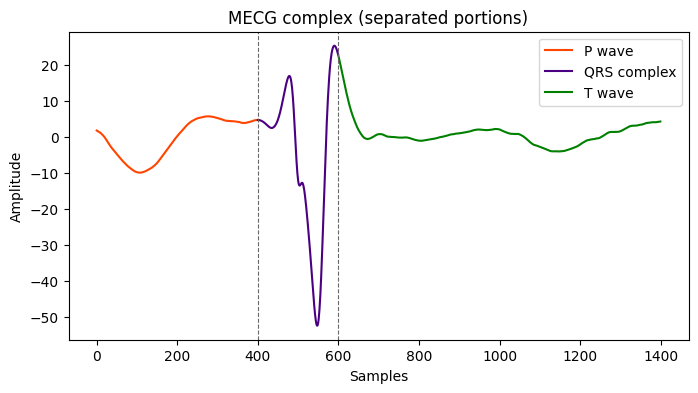

In [35]:
# plot delle porzioni di mu di una singola realizzazione, a titolo di esempio
mu = mu_portions["AECG1"]

x1 = np.arange(len(mu[0]))
x2 = np.arange(len(mu[1])) + len(mu[0])
x3 = np.arange(len(mu[2])) + len(mu[0]) + len(mu[1])

plt.figure(figsize=(8, 4))

plt.plot(x1, mu[0], label="P wave", color='orangered')
plt.plot(x2, mu[1], label="QRS complex", color='indigo')
plt.plot(x3, mu[2], label="T wave", color='green')

plt.axvline(len(mu[0]), color='dimgrey', linewidth=0.8, linestyle='--')
plt.axvline(len(mu[0]) + len(mu[1]), color='dimgrey', linewidth=0.8, linestyle='--')

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("MECG complex (separated portions)")
plt.legend()
plt.show()

In [36]:
# salvataggio delle matrici M in un dizionario:
# M_matrixes["AECG1"] -> matrice M associata ad AECG1
# M_matrixes["AECG2"] -> matrice M associata ad AECG2
# M_matrixes["AECG3"] -> matrice M associata ad AECG3
# M_matrixes["AECG4"] -> matrice M associata ad AECG4

def matrix_constructor(mu_P, mu_QRS, mu_T):
    col_1 = np.concatenate([mu_P, np.zeros(len(mu_QRS) + len(mu_T))])
    col_2 = np.concatenate([np.zeros(len(mu_P)), mu_QRS, np.zeros(len(mu_T))])
    col_3 = np.concatenate([np.zeros(len(mu_P) + len(mu_QRS)), mu_T])
    return np.column_stack([col_1, col_2, col_3])

def get_M_matrixes(mu_portions):
    M_matrixes = {}
    for realization in mu_portions: M_matrixes[realization] = matrix_constructor(mu_portions[realization][0], mu_portions[realization][1], mu_portions[realization][2])
    return M_matrixes
#--------------------------------------------------------------------------------------------------------------------------------------

M_matrixes = get_M_matrixes(mu_portions)

In [37]:
# restituisce a, un array di tre valori così definito:
# a[0] = a_P : coefficienti di scaling ottimali da applicare all'onda P
# a[1] = a_QRS : coefficienti di scaling ottimali da applicare al complesso QRS
# a[2] = a_T : coefficienti di scaling ottimali da applicare all'onda T
def get_optimized_scaled_values(M, m):
    MT = M.T
    MTM = np.dot(MT, M)
    MTM_inv = np.linalg.inv(MTM)
    MTm = np.dot(MT, m)
    return np.dot(MTM_inv, MTm)

# restituisce un array contenente le versioni di onda P, complesso QRS e onda T scalate secondo i coefficienti ottimizzati contenuti in a
def get_scaled_ECG_complex(a, mu_P, mu_QRS, mu_T):
    scaled_P = mu_P*a[0]
    scaled_QRS = mu_QRS*a[1]
    scaled_T = mu_T*a[2]
    return np.concatenate([scaled_P, scaled_QRS, scaled_T])

In [38]:
# salvataggio dei complessi ECG materni STIMATI per ogni realizzazione in un dizionario:
# estimated_MECGs_dict["AECG1"] -> [[estimated_MECG_1_1], [estimated_MECG_1_2], ..., [estimated_MECG_1_N]]
# estimated_MECGs_dict["AECG2"] -> [[estimated_MECG_2_1], [estimated_MECG_2_2], ..., [estimated_MECG_2_N]]
# estimated_MECGs_dict["AECG3"] -> [[estimated_MECG_3_1], [estimated_MECG_3_2], ..., [estimated_MECG_3_N]]
# estimated_MECGs_dict["AECG4"] -> [[estimated_MECG_4_1], [estimated_MECG_4_2], ..., [estimated_MECG_4_N]]

def get_estimated_ECGs(real_ECGs, M_matrixes, mu_portions):
    estimated_ECGs = {}
    for realization in real_ECGs:
        estimated_ECGs[realization] = []
        current_ECGs = real_ECGs[realization]
        M = M_matrixes[realization]
        K =  len(current_ECGs)
        for i in range(K):
            real_complex = current_ECGs[i]
            a = get_optimized_scaled_values(M, real_complex)
            mu_P, mu_QRS, mu_T = mu_portions[realization][0], mu_portions[realization][1], mu_portions[realization][2]
            estimated_ECGs[realization].append(get_scaled_ECG_complex(a, mu_P, mu_QRS, mu_T))

    return estimated_ECGs

#--------------------------------------------------------------------------------------------------------------------------------------

estimated_MECGs = get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)

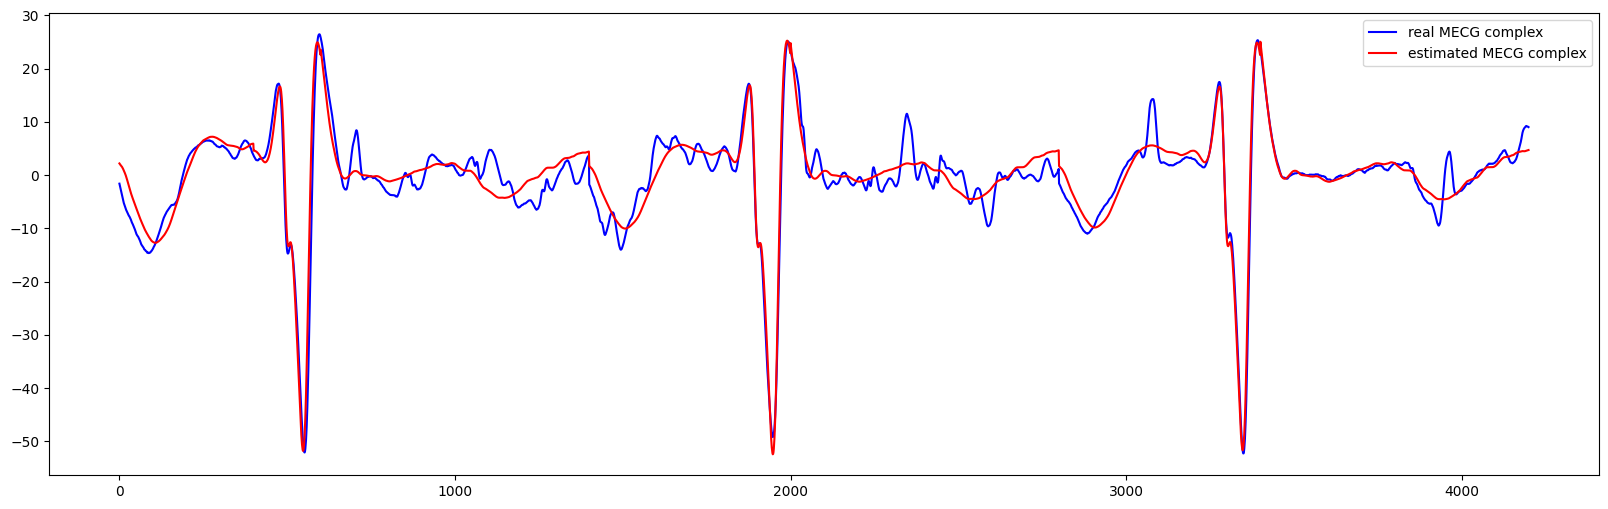

In [39]:
# plot delle prime tre componenti MECG reali e di quelle stimate per la prima realizzazione (a titolo di esempio)
first_three_reals_MECGs = np.concatenate([real_MECGs["AECG1"][0], real_MECGs["AECG1"][1], real_MECGs["AECG1"][2]])
first_three_estimated_MECGs = np.concatenate([estimated_MECGs["AECG1"][0], estimated_MECGs["AECG1"][1], estimated_MECGs["AECG1"][2]])

plt.figure(figsize=(20, 6))
plt.plot(first_three_reals_MECGs, color='blue', label="real MECG complex")
plt.plot(first_three_estimated_MECGs, color='red', label="estimated MECG complex")
plt.legend()
plt.show()

In [40]:
# cancel_MECG parte dal segnale originale (upsampled) e sottrae gli MECG stimati solo nelle porzioni relative agli MECG reali
# il segnale risultate conterrà solo ECG fetale e altre interferenze/rumori di misurazione
def cancel_MECG(original_realization, ECG_positions, real_ECGs, estimated_ECGs):
    output = original_realization.copy()
    K = len(ECG_positions)
    for i in range(K):
        start_i_complex, end_i_complex = ECG_positions[i][0], ECG_positions[i][1]
        residual = real_ECGs[i] - estimated_ECGs[i]
        output[start_i_complex:end_i_complex] = residual
    return output

In [41]:
# processo stocastico contenente i segnali a seguito della sottrazione dell ECG materno
residual_SP = []

for i in range(N):
    realization = realizations[i]
    residual_SP.append(cancel_MECG(upsampled_SP[i], real_MECGs_positions[realization], real_MECGs[realization], estimated_MECGs[realization]))

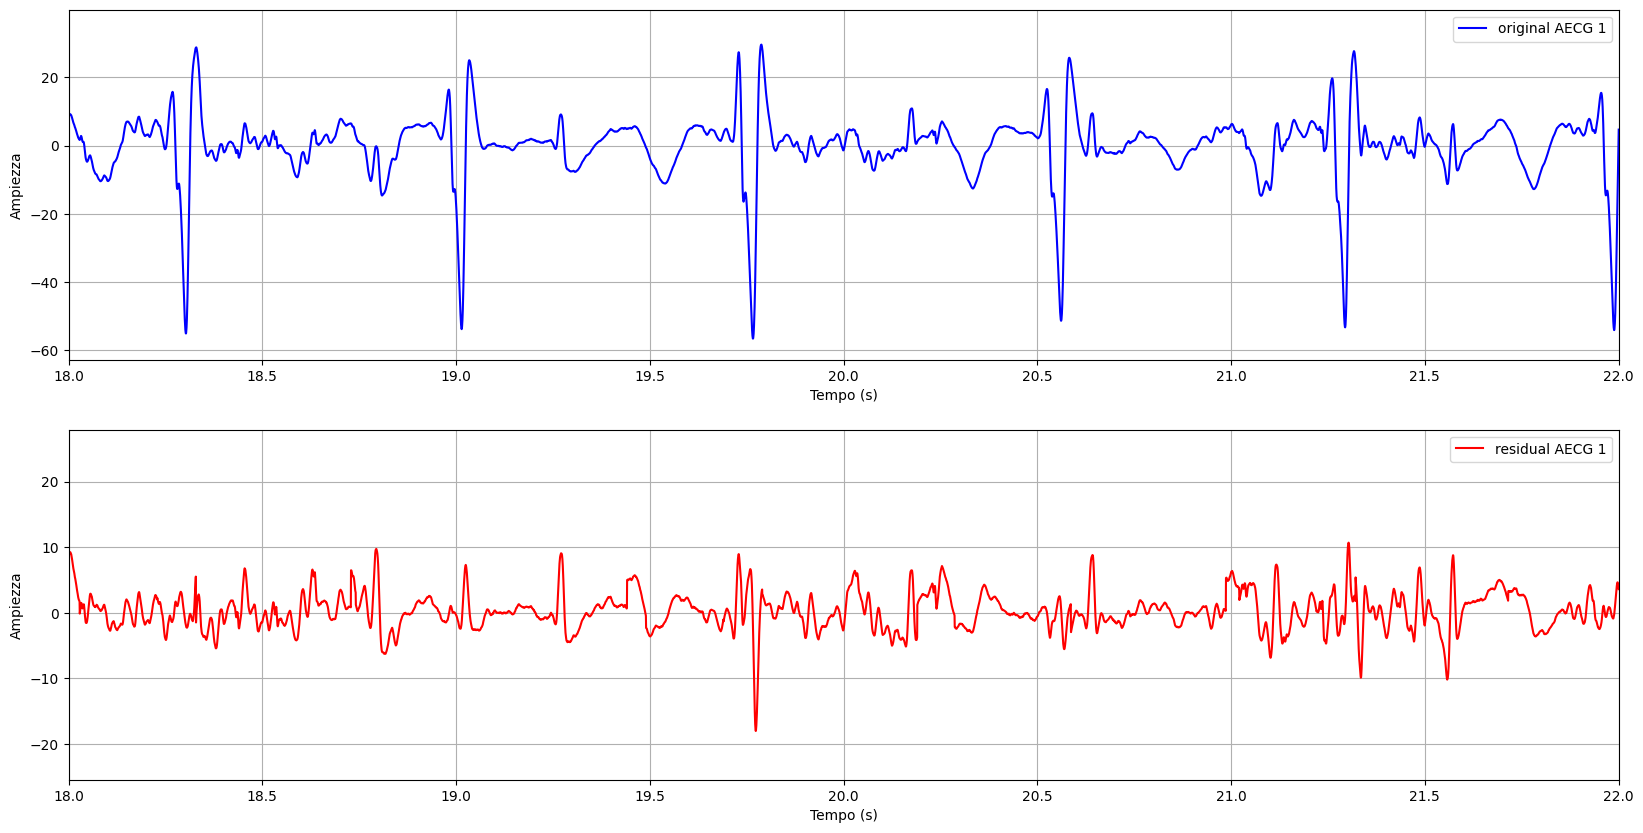

In [42]:
# plot del confronto tra la prima realizzazione originale e la prima realizzazione a seguito della sottrazione dell'ECG materno, a titolo di esempio

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(upsampled_time, upsampled_SP[0], color='blue', label="original AECG 1")
plt.legend()
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(upsampled_time, residual_SP[0], color='red', label="residual AECG 1")
plt.legend()
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

plt.show()

# **Fetal QRS Detector**

la procedura è la stessa usata per l'ECG materno:

processo stocastico → enhanced_QRS → QRS_template → correlazione tra QRS_template e enhanced_QRS

In [43]:
# PICCHI FETALI REALI (GROUND TRUTH)
with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])

# adattamento alla nuova frequenza di campionamento
real_fetal_peaks = gt * 2

varianza spiegata: 44%
lunghezza template QRS fetale in campioni: 186


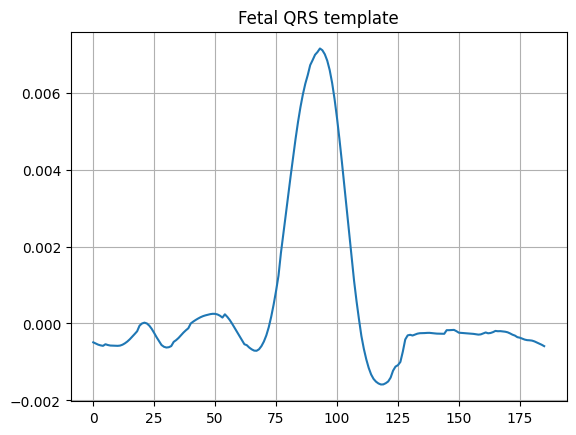

In [44]:
fetal_enhanced_QRS, fetal_explained_variance = get_enhanced_QRS(residual_SP)
print(f"varianza spiegata: {round(fetal_explained_variance)}%")

# in maniera molto empirica, si nota che con questo valore di template fetale i picchi stimati si allineano
# molto vicini ai picchi di ground truth
fetal_duration_template_seconds = 0.0935

fetal_QRS_template = create_qrs_template(fetal_enhanced_QRS, new_sf, fetal_duration_template_seconds)

print(f"lunghezza template QRS fetale in campioni: {len(fetal_QRS_template)}")
plt.plot(fetal_QRS_template)
plt.title('Fetal QRS template')
plt.grid(True)
plt.show()

picchi QRS rilevati: 65 con soglia di correlazione del 30 %
picchi QRS di ground truth: 145


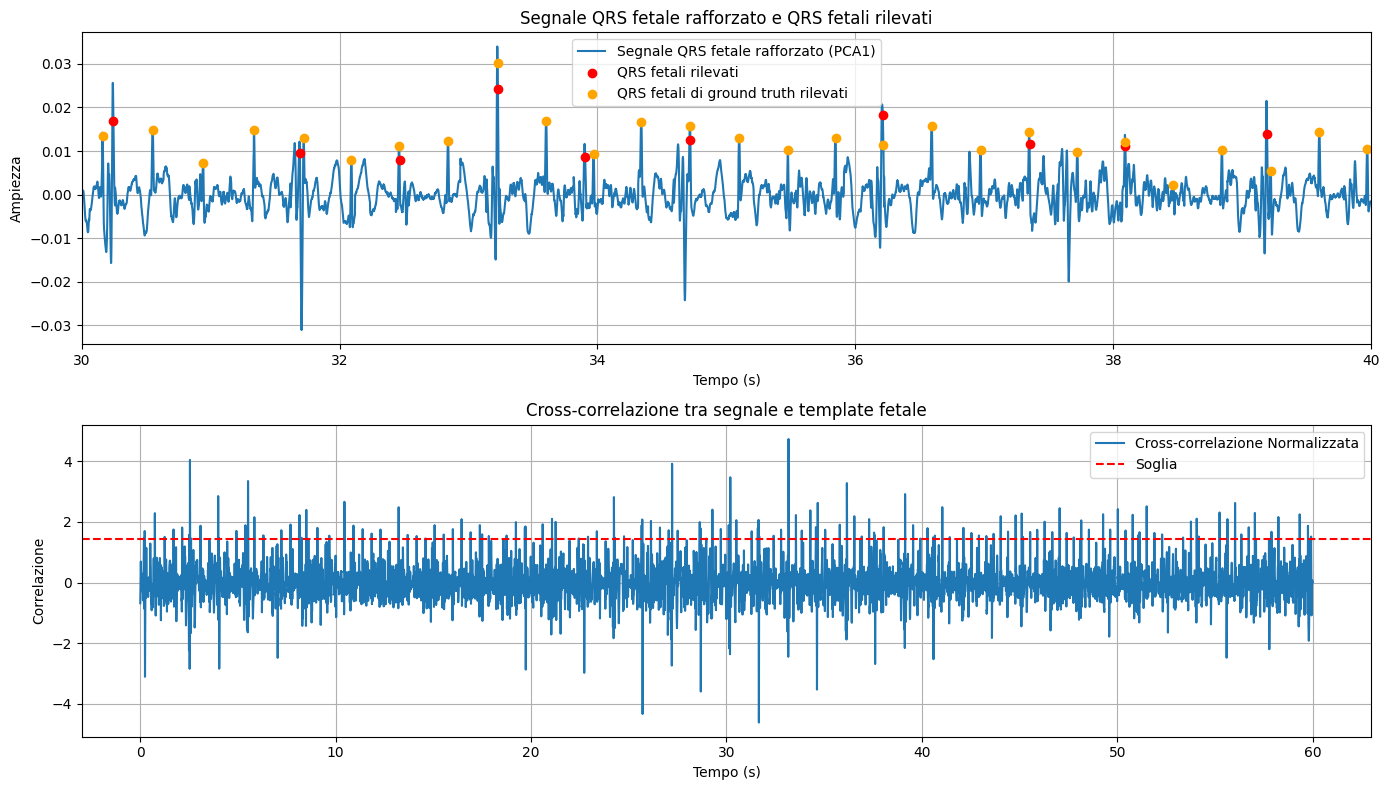

In [45]:
fetal_threshold_factor = 0.30
fetal_peaks, fetal_cross_corr = detect_qrs(fetal_enhanced_QRS, fetal_QRS_template, new_sf, threshold_factor=fetal_threshold_factor)

fetal_corr_max = np.max(fetal_cross_corr)
print(f"picchi QRS rilevati: {len(fetal_peaks)} con soglia di correlazione del {round(fetal_threshold_factor*100)} %")
print(f"picchi QRS di ground truth: {len(real_fetal_peaks)}")

# Visualizzazione del risultato
plt.figure(figsize=(14, 8))

# Segnale originale con i QRS rilevati
plt.subplot(2, 1, 1)
plt.plot(upsampled_time, fetal_enhanced_QRS, label="Segnale QRS fetale rafforzato (PCA1)")
plt.scatter(upsampled_time[fetal_peaks], fetal_enhanced_QRS[fetal_peaks], color='red', label="QRS fetali rilevati", zorder=2)
plt.scatter(upsampled_time[real_fetal_peaks], fetal_enhanced_QRS[real_fetal_peaks], color='orange', label="QRS fetali di ground truth rilevati", zorder=2)
plt.legend()
plt.title("Segnale QRS fetale rafforzato e QRS fetali rilevati")
plt.xlabel("Tempo (s)")
plt.xlim(30, 40)
plt.ylabel("Ampiezza")
plt.grid()

# Cross-correlazione
plt.subplot(2, 1, 2)
plt.plot(upsampled_time[:len(fetal_cross_corr)], fetal_cross_corr, label="Cross-correlazione Normalizzata")
plt.axhline(y=fetal_threshold_factor*fetal_corr_max, color='red', linestyle='--', label="Soglia")
plt.legend()
plt.title("Cross-correlazione tra segnale e template fetale")
plt.xlabel("Tempo (s)")
plt.ylabel("Correlazione")
plt.grid()

plt.tight_layout()
plt.show()

# **Fetal QRS Detector**

Il procedimento è lo stesso utilizzato sopra: una volta estrapolati i picchi vengono estratte le finestre associate ai complessi ECG fetali e vengono mediate, in modo tale da ottenere una stima del complesso ECG fetale per ciascuna realizzazione

In [46]:
fetal_P_wave_duration_seconds = 0.20
fetal_T_wave_duration_seconds = 0.40

samples_before_FQRS = get_samples_around_QRS(P_wave_duration_seconds, duration_template_seconds, new_sf)
samples_after_FQRS = get_samples_around_QRS(T_wave_duration_seconds, duration_template_seconds, new_sf)

real_FECGs, _ = get_real_ECGs(residual_SP, realizations, samples_before_FQRS, samples_after_FQRS, fetal_peaks)
gt_FECGs, _ = get_real_ECGs(residual_SP, realizations, samples_before_FQRS, samples_after_FQRS, real_fetal_peaks)

FECG_averages = get_ECG_averages(real_FECGs)
gt_FECG_averages = get_ECG_averages(gt_FECGs)

# **Metriche di valutazione**
Utilizzate per confrontare quanto, per ciascuna realizzazione, il complesso ECG fetale medio calcolato sui picchi QRS stimati si avvicina al complesso ECG fetale medio calcolato sui picchi QRS di ground truth

- **Correlazione**: per avere una misura più qualitativa della forma dell'FECG
- **Errore quadratico medio**: valutare la differenza quantitativa in termini di ampiezza dei due complessi ECG

In [47]:
correlations = {}
MSEs = {}

for realization in realizations:
    estimate = FECG_averages[realization]
    truth = gt_FECG_averages[realization]
    correlations[realization] = np.corrcoef(estimate, truth)[0, 1]
    MSEs[realization] = np.mean((estimate - truth)**2)


--------------------------------AECG1--------------------------------

Correlazione per realizzazione AECG1 = 0.8325581110144282

MSE per realizzazione AECG1 = 0.6203346734954838



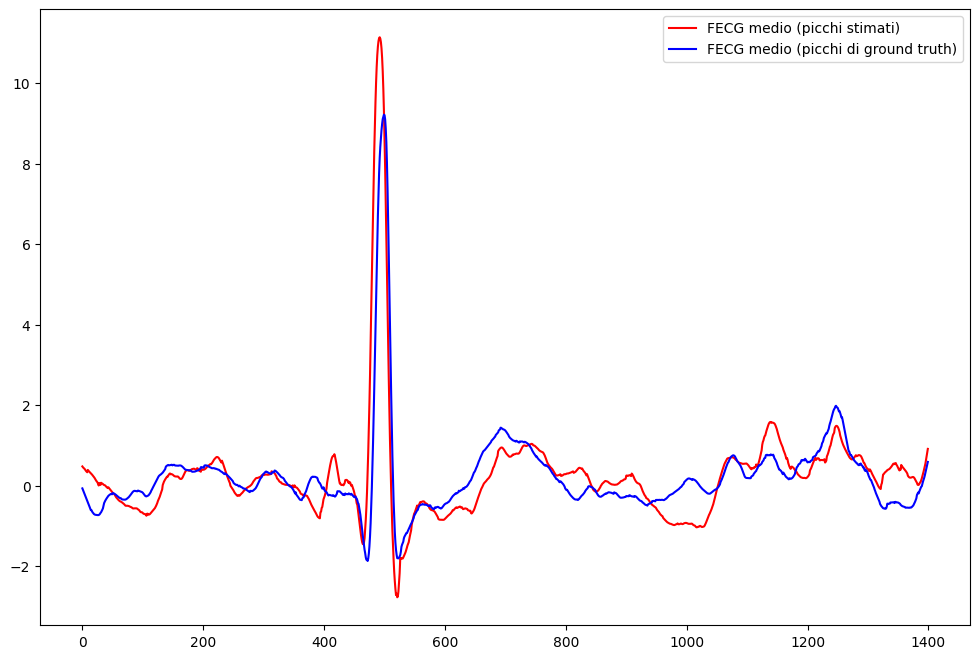


--------------------------------AECG2--------------------------------

Correlazione per realizzazione AECG2 = 0.46165456807333183

MSE per realizzazione AECG2 = 0.6260288521695898



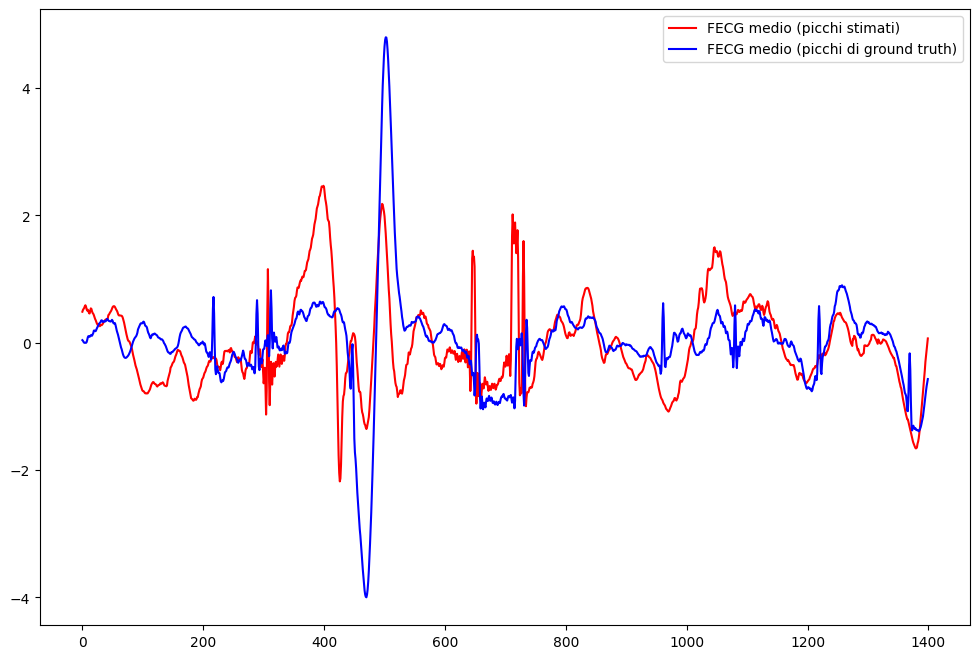


--------------------------------AECG3--------------------------------

Correlazione per realizzazione AECG3 = 0.7459994144311748

MSE per realizzazione AECG3 = 0.15151915669453303



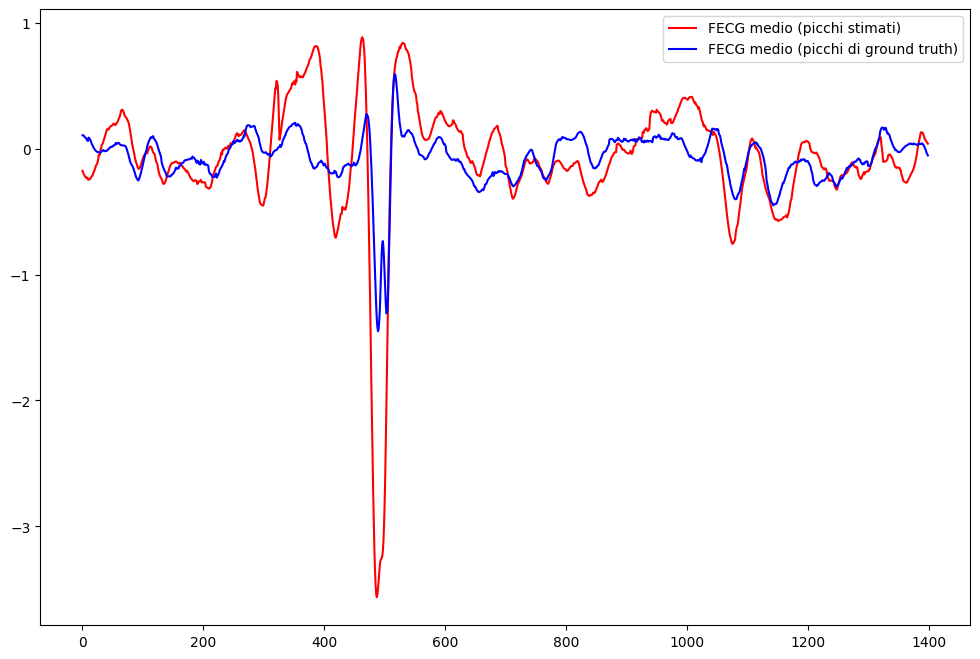


--------------------------------AECG4--------------------------------

Correlazione per realizzazione AECG4 = 0.868049142741773

MSE per realizzazione AECG4 = 0.210356051326347



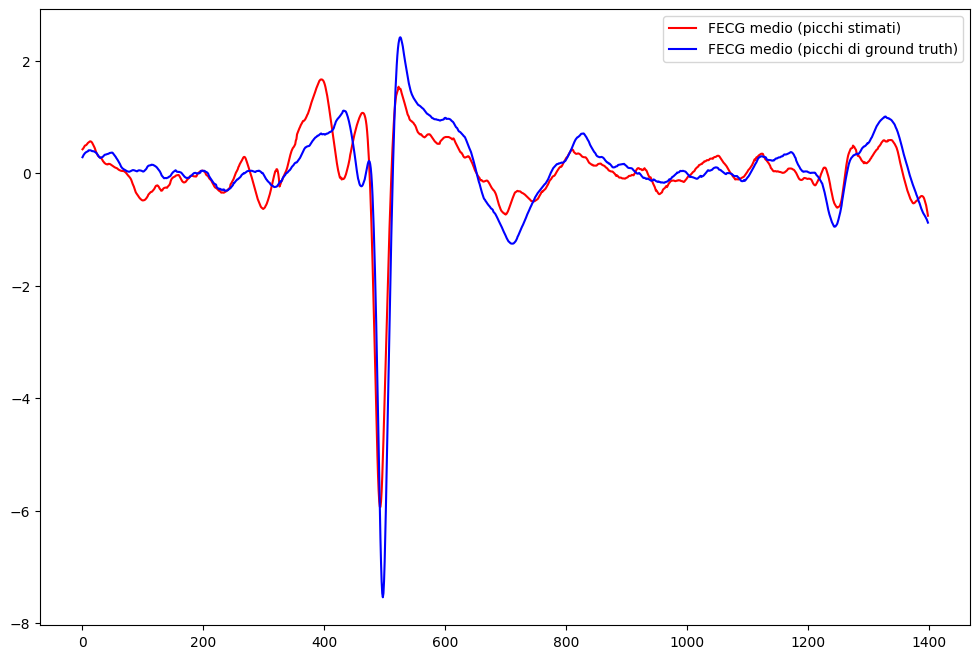

In [48]:
def plot_results(estimates, truths, realization, correlations, MSEs):
    print(f"\n--------------------------------{realization}--------------------------------\n")
    print(f"Correlazione per realizzazione {realization} = {correlations[realization]}\n")
    print(f"MSE per realizzazione {realization} = {MSEs[realization]}\n")
    plt.figure(figsize=(12, 8))
    plt.plot(estimates[realization], color='red', label=f"FECG medio (picchi stimati)")
    plt.plot(truths[realization], color='blue', label=f"FECG medio (picchi di ground truth)")
    plt.legend()
    plt.show()

for realization in realizations:
    plot_results(FECG_averages, gt_FECG_averages, realization, correlations, MSEs)

In [49]:
# correlazione ed MSE medi finali:
corr_mean = np.mean([correlations[realization] for realization in correlations])
MSE_mean = np.mean([MSEs[realization] for realization in MSEs])

print(f"Correlazione media finale: {corr_mean}")
print(f"Errore quadratico medio finale: {MSE_mean}")

Correlazione media finale: 0.7270653090651771
Errore quadratico medio finale: 0.4020596834214884
